In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sladsnet.code.training as training
from sladsnet.input_params import TrainingInputParams
from sladsnet.code.training import SimulatedSampleParams
from sladsnet.code.erd import SladsModelParams
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import joblib
import dataclasses as dt
from tqdm.notebook import tqdm

In [3]:
base_path = Path.cwd().parent

In [7]:
cameraman_path = base_path / 'ResultsAndData/TrainingData/cameraman/'

In [8]:
input_images_p

True

In [10]:
train_params = TrainingInputParams(input_images_path = cameraman_path / 'Images',
                                   output_dir=cameraman_path)

In [9]:
training.generate_training_databases(train_params)

  0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/1 [00:00<?, ?it/s]

Masks:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Set Separation:   0%|          | 0/100 [00:00<?, ?it/s]

Size of training database is 90
Size of validation database is 10
training db...
validation db...


In [11]:
val_scores = {}
for c_value in tqdm(train_params.test_c_values):
    
    print('test c', c_value)
    train_db_path = base_path / Path(f'c_{c_value}') / f'training_database.pkl'
    validation_db_path = base_path / Path(f'c_{c_value}') / f'validation_database.pkl'
    
    val_scores[c_value] = []
    
    
    for activation in ['relu']:
        print('test activation', activation)
        save_path = train_db_path.parent / f'erd_model_{activation}.pkl'
        erd_model, _ = training.fit_erd_model(training_db_path=train_db_path, 
                                              model_params=SladsModelParams(activation=activation),
                                              save_path=save_path)
        score = training.validate_erd_model_r_squared(validation_db_path=validation_db_path,
                                                      erd_model_path=save_path)
        print('R squared score', score)
        val_scores[c_value].append(score)
        #model = nnr(**dt.asdict(params))
        #train_losses_this = []
        #val_losses_this = []
        #train_scores_this = []
        #val_scores_this = []
        #for i in tqdm(range(10), leave=False):
        #    model.partial_fit(features_all, erds_all)
        #    train_losses_this.append(model.loss_)
        #    if i % 2 == 0:
        #        train_scores_this.append(model.score(features_all, erds_all))
        #
        #    preds = model.predict(val_features_all)
        #    val_loss = 0.5 * np.sum(np.abs(preds - val_erds_all)**2 / len(val_features_all))
        #    val_losses_this.append(val_loss)
        #    if i % 2 == 0:
        #        val_scores_this.append(model.score(val_features_all, val_erds_all))
        #train_losses[c_value].append(train_losses_this)
        #val_losses[c_value].append(val_losses_this)
        #train_scores[c_value].append(train_scores_this)
        #val_scores[c_value].append(val_scores_this)
    


  0%|          | 0/1 [00:00<?, ?it/s]

test c 16
test activation relu
R squared score 0.5788043807594707


### Testing the actual sampling procedure 

In [9]:
import tifffile as tif

In [54]:
from sladsnet.input_params import ERDInputParams, GeneralInputParams
from sladsnet.code.measurement_interface import TransmissionSimulationMeasurementInterface
from sladsnet.code.results import Result
from sladsnet.code.base import SimulatedSample
from sladsnet.code.sampling import run_sampling
from sladsnet.code.erd import SladsSklearnModel
from sladsnet.code.neighbors import find_neighbors

In [70]:
imgs_path = Path(train_params.input_images_path)
tif_names = imgs_path.glob('*.tif')

img_data_all = [tif.imread(f) for f in tif_names]
rng = np.random.default_rng()
sample_params = SimulatedSampleParams(image=img_data_all[0], points_to_scan=1,
                                     initial_scan_ratio=0.01,
                                     stop_ratio=0.2,
                                     scan_method='pointwise',
                                     scan_type='transmission',
                                     rng=rng)

In [78]:
results = Result()

In [79]:
measurement_interface = TransmissionSimulationMeasurementInterface(sample_params.image.copy())

In [80]:
erd_model = SladsSklearnModel(load_path=base_path / Path(f'c_16/erd_model_relu.pkl'))

In [81]:
sample = SimulatedSample(simulation_type='c_opt',
                                  sample_params=sample_params,
                                  general_params=params_gen,
                                  erd_params=params_erd,
                                  measurement_interface=measurement_interface,
                                  erd_model=erd_model)

In [82]:
run_sampling(sample, max_iterations=5000, results=results, results_frequency=500, disable_progress_bar=False)

% sampled:   0%|          | 0/20.0 [00:00<?, ?it/s]

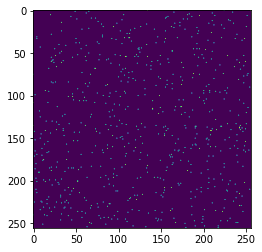

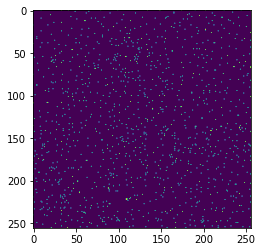

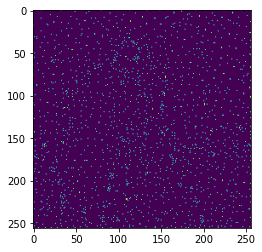

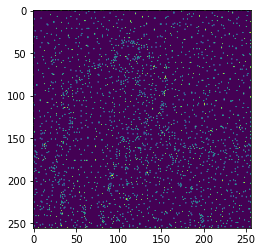

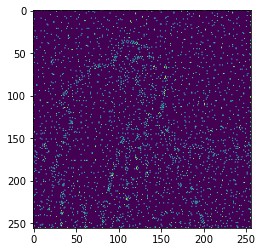

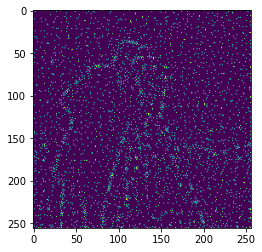

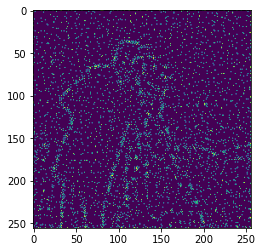

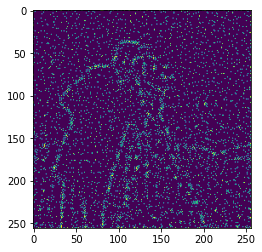

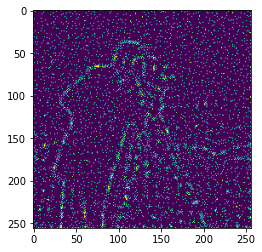

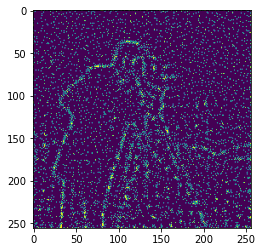

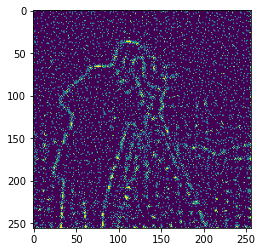

In [83]:
for mask in results.outputs.masks:
    plt.imshow(mask)
    plt.show()

In [84]:
errors = [np.abs(r - sample_params.image).mean() for r in results.outputs.recons]

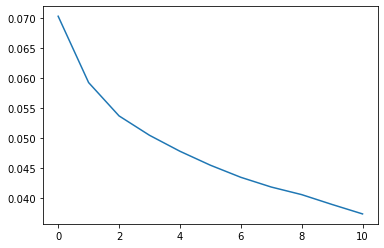

In [85]:
plt.plot(errors)

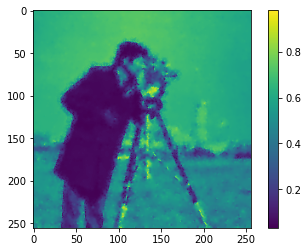

In [86]:
plt.imshow(results.outputs.recons[-1])
plt.colorbar()
plt.show()